# Data_Exploration

This notebook describes the data exploration step before building models for salary prediction. The library `utils` is used for data quality check, exploartion, transformation and visulization.

In [1]:
import utils
import gc
from sklearn.model_selection import train_test_split

## 1. Load Data Sets

In [2]:
import pandas as pd
train_features = pd.read_csv('train_features.csv')
train_salaries = pd.read_csv('train_salaries.csv')

Check several rows of training features and target varible. Merge the training features to target varible salary by `jobId`

In [3]:
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [4]:
train_salaries.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [5]:
training = train_salaries.merge(train_features, on = 'jobId', how = 'left')

In [6]:
target = 'salary'

## 2. Data Quality Check

* No variables with missing values detected in this data set. 
* Five observations with salary values are zeros, they seems to be data errors instead of volunteer jobs. They will be removed in outliers checking
* Assume values in `salary` are in unit of 1,000. e.g. 25 means $ 25,000 base salary annually

In [7]:
utils.miss_val_per(training)

[]


In [8]:
training.describe()

,salary,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000,1000000.000000
mean,116.061818,11.992386,49.529260
std,38.717936,7.212391,28.877733
min,0.000000,0.000000,0.000000
25%,88.000000,6.000000,25.000000
50%,114.000000,12.000000,50.000000
75%,141.000000,18.000000,75.000000
max,301.000000,24.000000,99.000000


In [9]:
training[training.salary <= 0]

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
30559,JOB1362684438246,0,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7
495984,JOB1362684903671,0,COMP34,JUNIOR,NONE,NONE,OIL,1,25
652076,JOB1362685059763,0,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60
816129,JOB1362685223816,0,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6
828156,JOB1362685235843,0,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29


## 3. Investigate the training features

### 3.1 Target variable

Target variable `salary` can be considered normal distributed

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


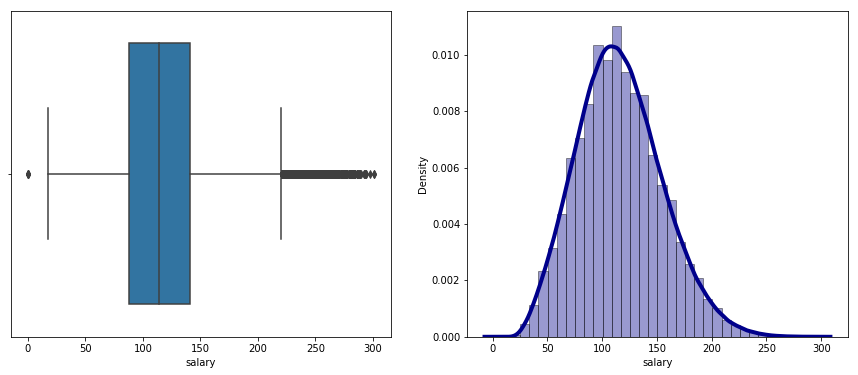

In [10]:
utils.check_target(training, target)    

consider to use a rule of thumb bounds to detect suspected outliers

In [11]:
stats = training['salary'].describe()
IQR = stats['75%'] - stats['25%']
upper_bound = stats['75%'] + 1.5 * IQR
lower_bound = stats['25%'] - 1.5 * IQR
print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper_bound, lower_bound))

The upper and lower bounds for suspected outliers are 220.5 and 8.5.


`salary` value less than 8.5 are all zeros, which is very limited (5 of them) and will be removed

In [12]:
lower_salary = training[training[target] < 8.5]
lower_salary

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
30559,JOB1362684438246,0,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7
495984,JOB1362684903671,0,COMP34,JUNIOR,NONE,NONE,OIL,1,25
652076,JOB1362685059763,0,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60
816129,JOB1362685223816,0,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6
828156,JOB1362685235843,0,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29


Salary values higher than 220.5 but `jobType` includes 'MANAGER', 'SENIOR', 'JUNIOR' or 'JANITOR' have 303 jobs

In [13]:
print('job types include', training['jobType'].unique())

job types include ['CFO' 'CEO' 'VICE_PRESIDENT' 'MANAGER' 'JUNIOR' 'JANITOR' 'CTO' 'SENIOR']


In [14]:
high_salary = training.loc[(training[target] > 220.5) & (training['jobType'].isin(['MANAGER', 'SENIOR', 'JUNIOR']))]
print(high_salary.shape)

(303, 9)


Then find `companyId` of these 303 jobs, check the salary distribution of 'CEO', 'CFO', 'CTO' in these companies. These 303 jobs have higher salary than higher management positions in their companies, which does not make sense and considers them as data errors.

In [15]:
companyIds = high_salary.companyId.unique()

In [16]:
check = training[(training['jobType'].isin(['CEO', 'CFO', 'CTO'])) & (training.companyId.isin(companyIds))]

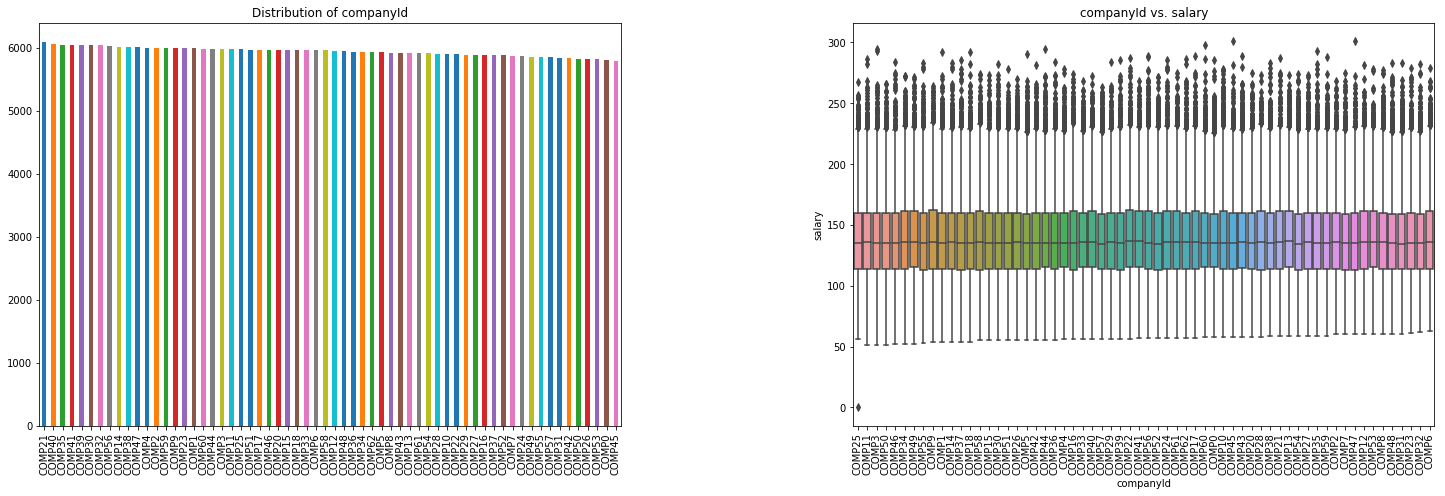

In [17]:
utils.plot_categorical_target(check, ['companyId'], target)

In [18]:
training = training[~training.jobId.isin(list(high_salary.jobId) + list(lower_salary.jobId))]
training.shape

(999692, 9)

In next two sections, we will investigate numerical and categorical_variables

In [19]:
categorical_vars = list(training.drop(['jobId', 'salary'], axis = 1).select_dtypes('object').columns)
numerical_vars = list(training.drop(['jobId', 'salary'], axis = 1).select_dtypes('int64').columns)
target = 'salary'
gc.collect()
print("numerical varibles are ", numerical_vars)
print("categorical_variables are ", categorical_vars)

numerical varibles are  ['yearsExperience', 'milesFromMetropolis']
categorical_variables are  ['companyId', 'jobType', 'degree', 'major', 'industry']


### 3.2 Numerical variable vs. target variables

#### Summary of numerical variables
* `yearsExperience` and `salary` are positive correlated
* `milesFromMetropolis` and `salary` are negative correlated

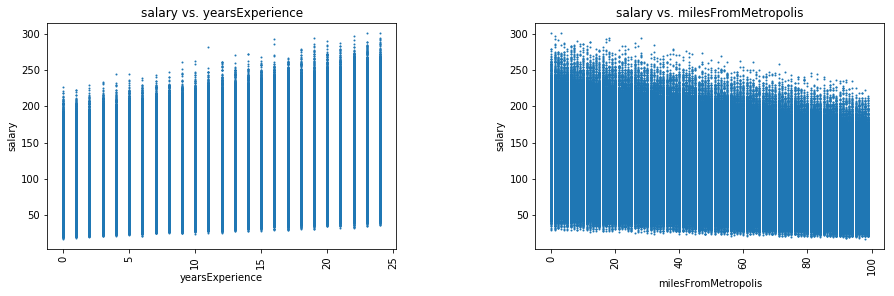

In [20]:
utils.plot_numerical_target(training, numerical_vars, target)

### 3.2 Categorical variables vs. target variables

#### Summary of categorical variables

* `companyId` has 63 levels and no obvious correlation with target `salary`. Thus, `CompanyId` will be dropped.
* "None" has much more volumes than other categories in `major`, will consider grouping other categories if having obvious correlation with target `salary` 
* Other categorical variables do have such situation that a category dominates and have obvious correlation with target `salary`. 

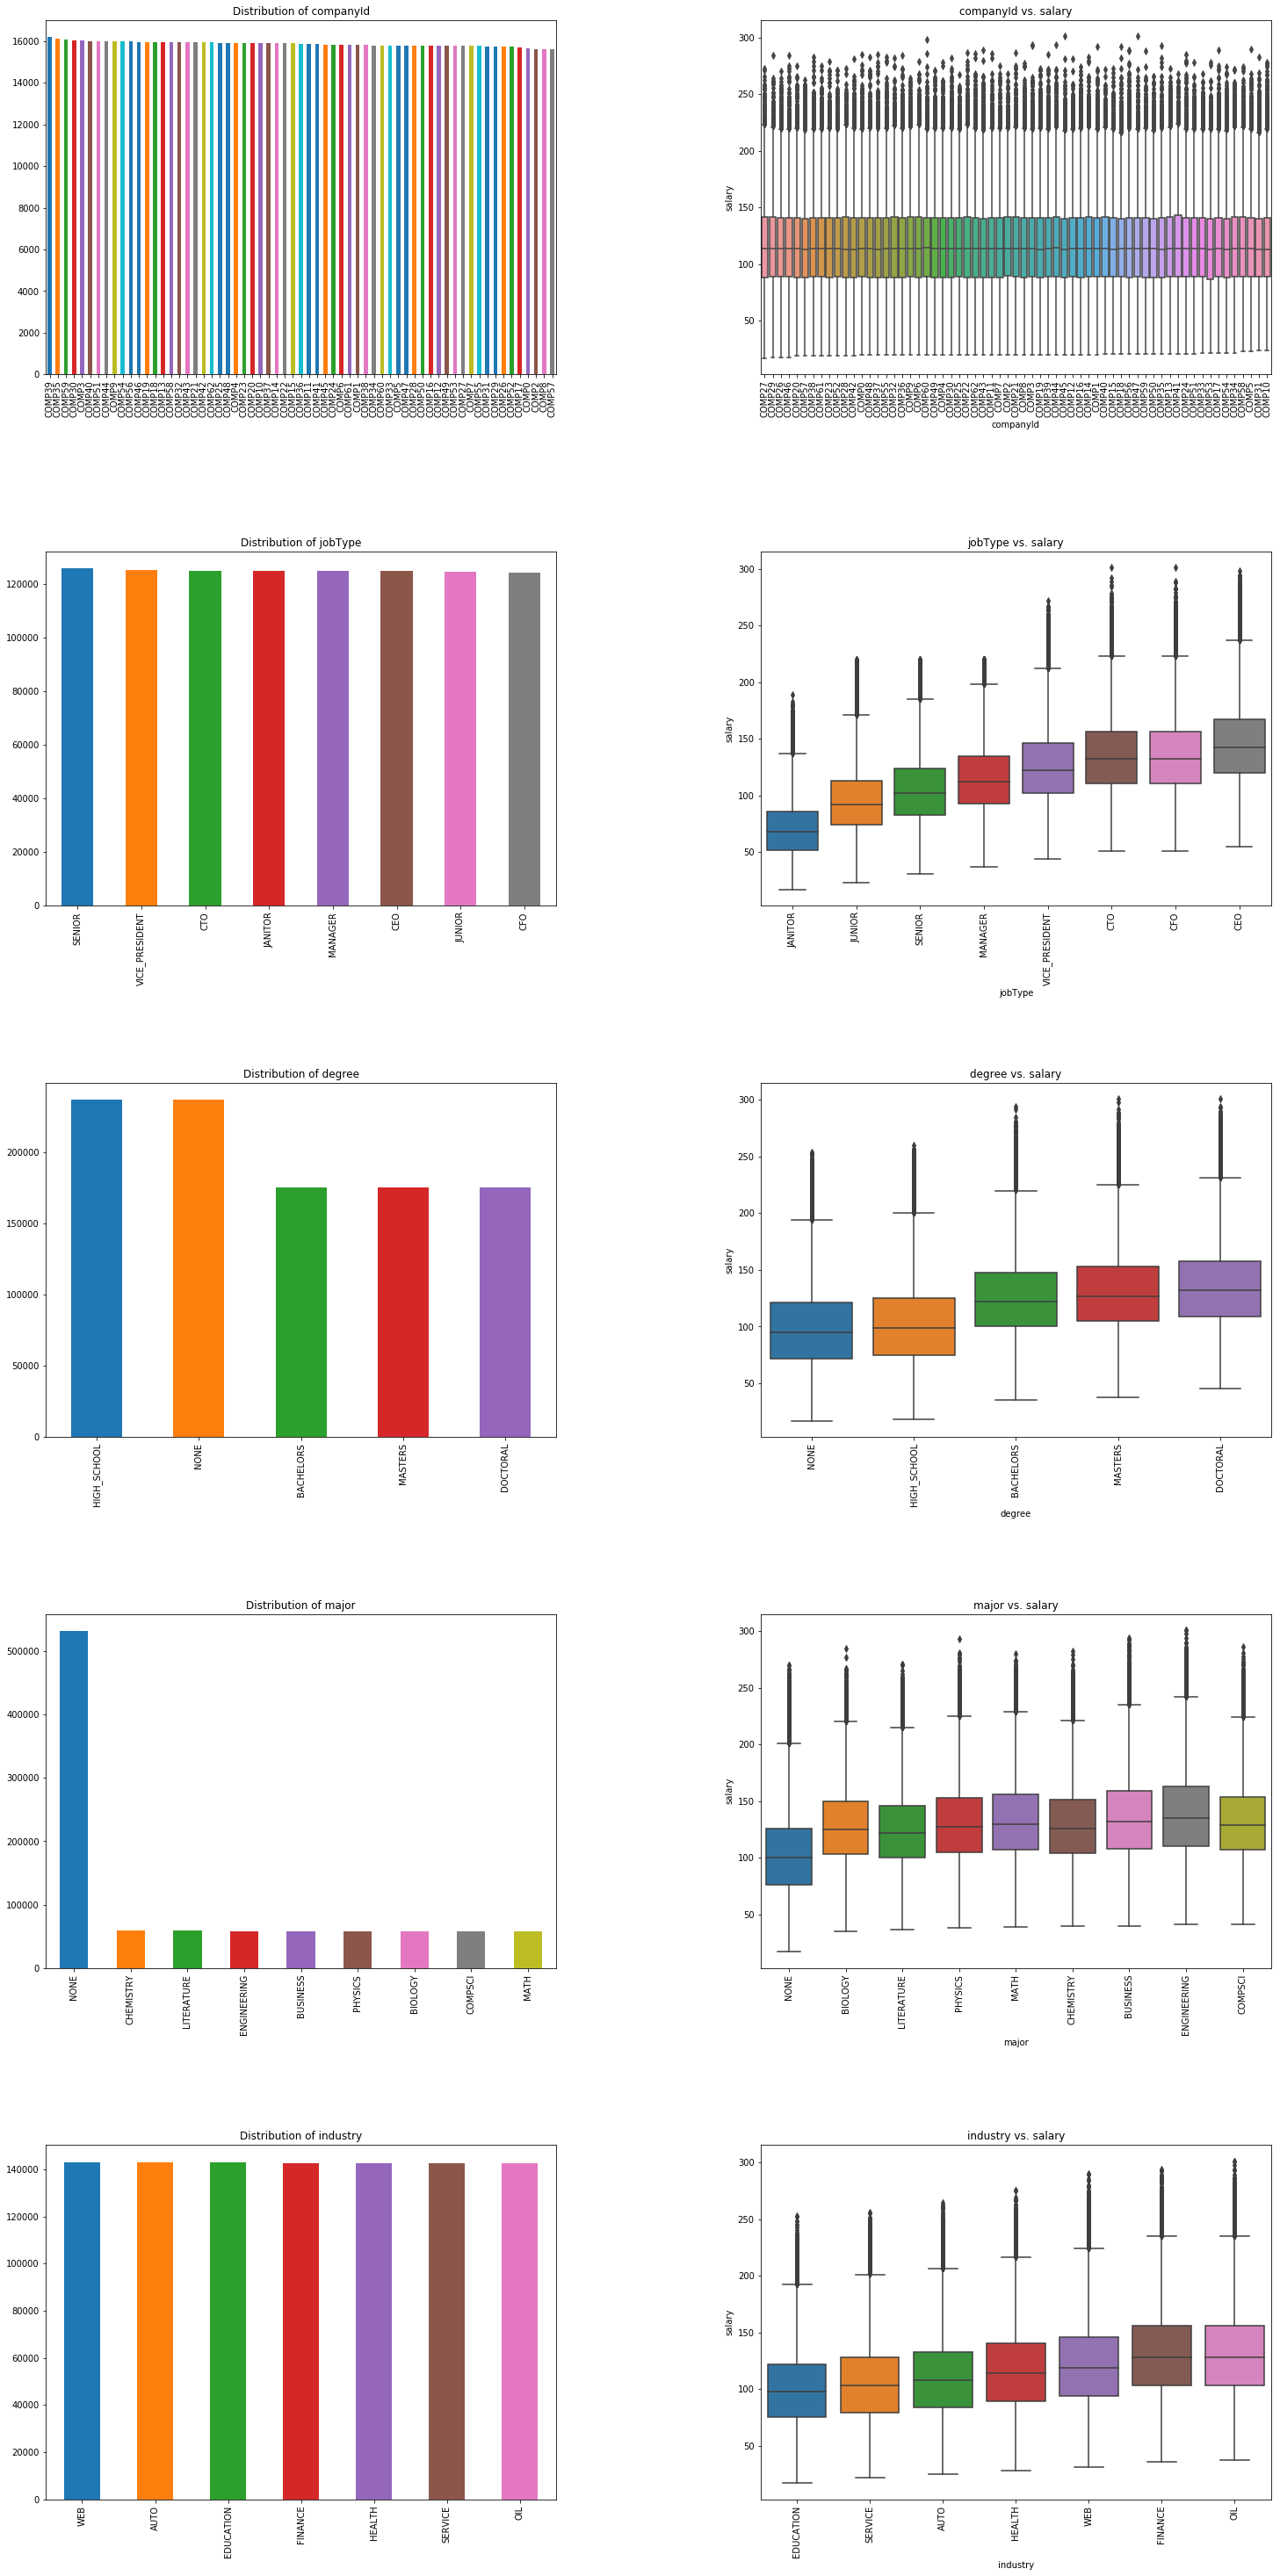

In [21]:
utils.plot_categorical_target(training, categorical_vars, target)

In [22]:
categorical_vars = [var for var in categorical_vars if var != 'companyId']

In [23]:
training = training.drop(['companyId'], axis = 1)

Since high school degree does not have major, considered to split a new category "NA" from "None" in `major` for high school degree observations. 

In [24]:
pd.crosstab(training.major, training.degree, dropna=False)

degree,BACHELORS,DOCTORAL,HIGH_SCHOOL,MASTERS,NONE
major,,,,,
BIOLOGY,19617,19395,0,19349,0
BUSINESS,19439,19499,0,19493,0
CHEMISTRY,19680,19568,0,19615,0
COMPSCI,19574,19316,0,19469,0
ENGINEERING,19650,19381,0,19454,0
LITERATURE,19420,19591,0,19669,0
MATH,19260,19335,0,19174,0
NONE,19498,19715,236972,19308,236853
PHYSICS,19305,19409,0,19684,0


In [25]:
training['major_test'] = training['major']
training.loc[(training.degree == 'HIGH_SCHOOL'),'major_test'] = 'NA'

In [26]:
pd.crosstab(training.major_test, training.degree, dropna=False)

degree,BACHELORS,DOCTORAL,HIGH_SCHOOL,MASTERS,NONE
major_test,,,,,
BIOLOGY,19617,19395,0,19349,0
BUSINESS,19439,19499,0,19493,0
CHEMISTRY,19680,19568,0,19615,0
COMPSCI,19574,19316,0,19469,0
ENGINEERING,19650,19381,0,19454,0
LITERATURE,19420,19591,0,19669,0
MATH,19260,19335,0,19174,0
NA,0,0,236972,0,0
NONE,19498,19715,0,19308,236853


The new category "NA" has very similar distribution to "None" category. Thus, do not have to create a new category for high school degree observations. 

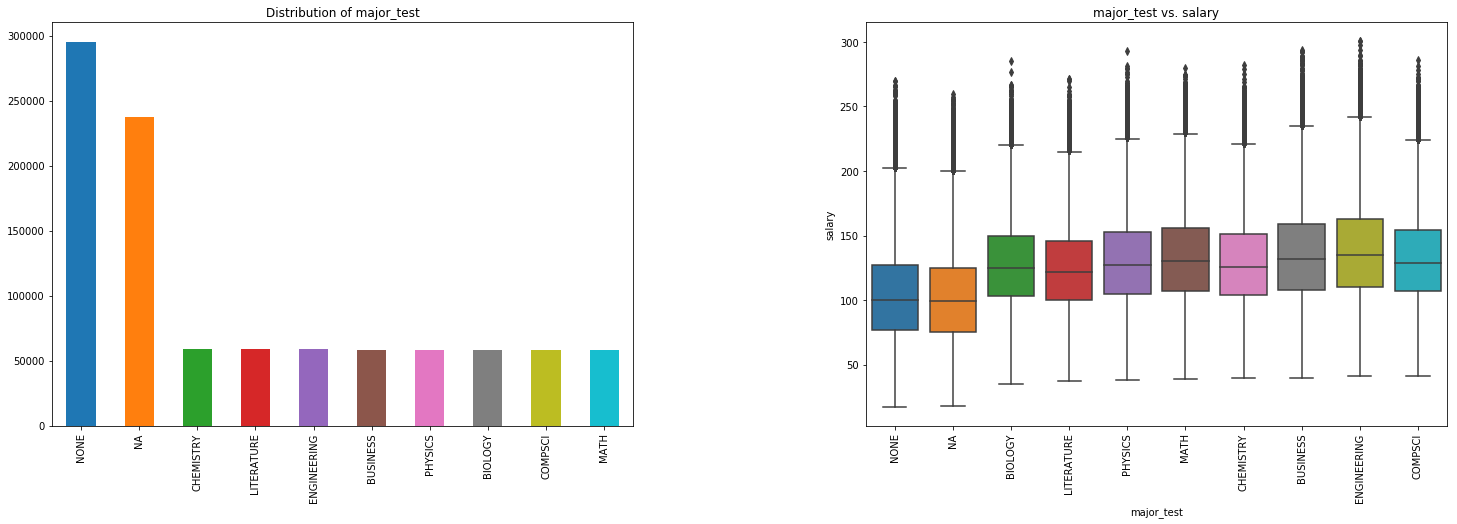

In [27]:
utils.plot_categorical_target(training, ["major_test"], target)

In [28]:
training = training.drop(['major_test'], axis = 1)

In [29]:
training.head()

,jobId,salary,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,130,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,101,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,137,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,142,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,163,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


Group categories other than "NONE" in `major` to create a new varible `major_new`. It will be compared to `major` in terms of model performance

In [30]:
training['major_new'] = training['major']
training.loc[(training.major != 'NONE'), 'major_new'] = 'Not None'

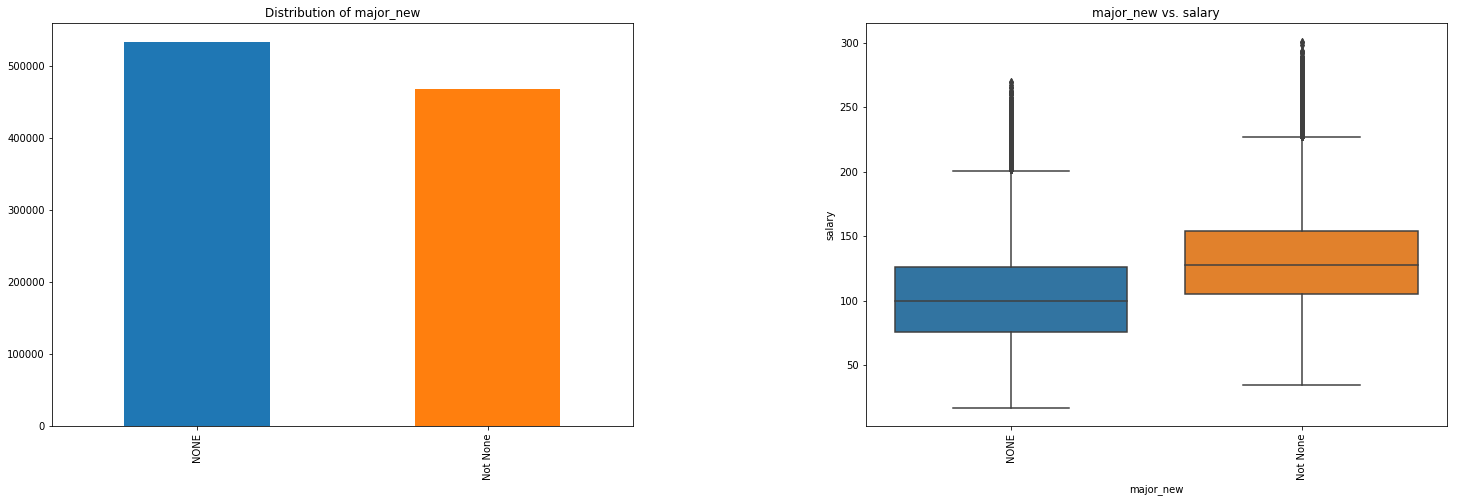

In [31]:
utils.plot_categorical_target(training, ["major_new"], target)

In [32]:
utils.describe_group(training, 'major', target)

,count,mean,std,min,25%,50%,75%,max
BIOLOGY,58361.0,127.902024,34.781670,35.0,103.0,125.0,150.0,285.0
BUSINESS,58431.0,135.505451,36.845073,40.0,108.0,132.0,159.0,294.0
CHEMISTRY,58863.0,129.052274,34.808187,40.0,104.0,126.0,151.0,282.0
COMPSCI,58359.0,132.038572,34.733218,41.0,107.0,129.0,154.0,286.0
ENGINEERING,58485.0,138.266513,37.996161,41.0,110.0,135.0,163.0,301.0
LITERATURE,58680.0,124.416155,33.567007,37.0,100.0,122.0,146.0,271.0
MATH,57769.0,133.268899,35.473845,39.0,107.0,130.0,156.0,280.0
NONE,532346.0,102.582249,36.133757,17.0,76.0,100.0,126.0,270.0
PHYSICS,58398.0,130.352324,34.931952,38.0,105.0,127.0,153.0,293.0


In [33]:
utils.describe_group(training, 'major_new', target)

,count,mean,std,min,25%,50%,75%,max
NONE,532346.0,102.582249,36.133757,17.0,76.0,100.0,126.0,270.0
Not None,467346.0,131.343020,35.653598,35.0,105.0,128.0,154.0,301.0


In [34]:
categorical_vars = categorical_vars + ['major_new']

In [35]:
gc.collect()

79260

## 4. Split training features and salary

The data frame `training` devided into three parts

* training data set (`X_train`, `y_train`), 60% of `training`: used with validation data set for hyperparameter tuning 
* validation data set (`X_val`, `y_val`), 20% of `training`: used with training data set for hyperparameter tuning 
* testing data set (`X_test`, `y_test`), 20% of `training`: used for comparing to other models

In [36]:
X_train, X_test, y_train, y_test = \
    train_test_split(training.drop(['jobId', 'salary'], axis = 1), training['salary'], \
                     test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

Distribution of (`X_train`, `y_train`), (`X_val`, `y_val`), (`X_test`, `y_test`) are very similary 

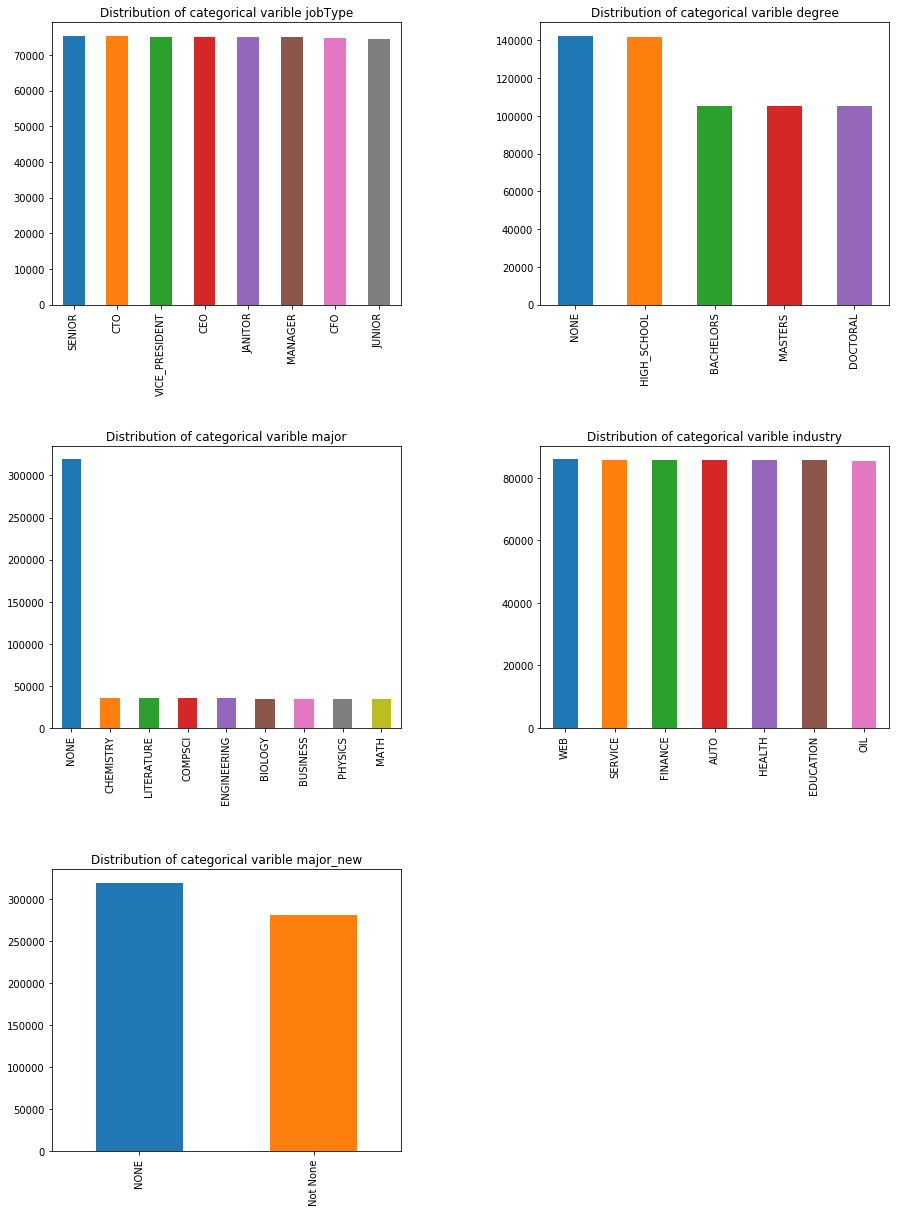

In [37]:
utils.plot_categorical_vars(X_train, categorical_vars)

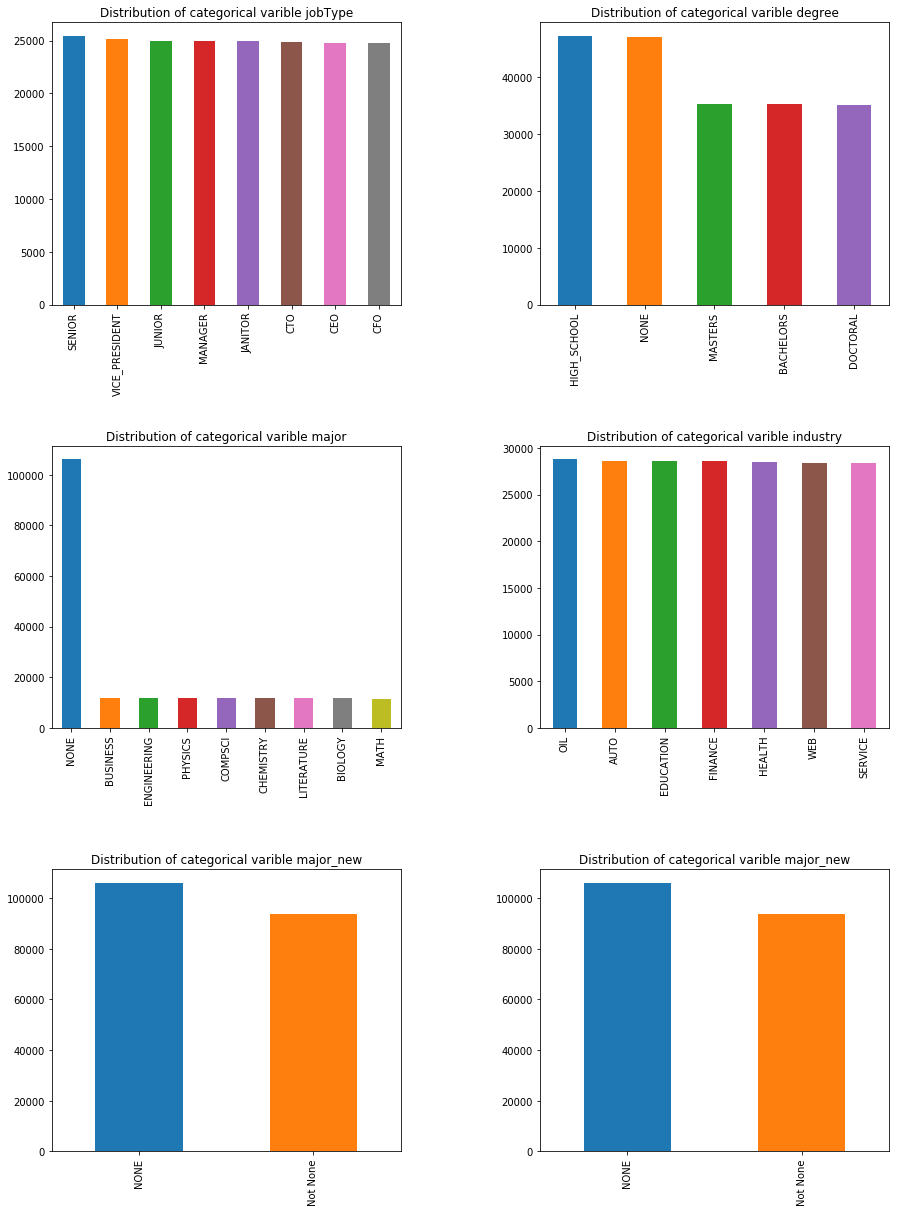

In [38]:
utils.plot_categorical_vars(X_val, categorical_vars + ['major_new'])

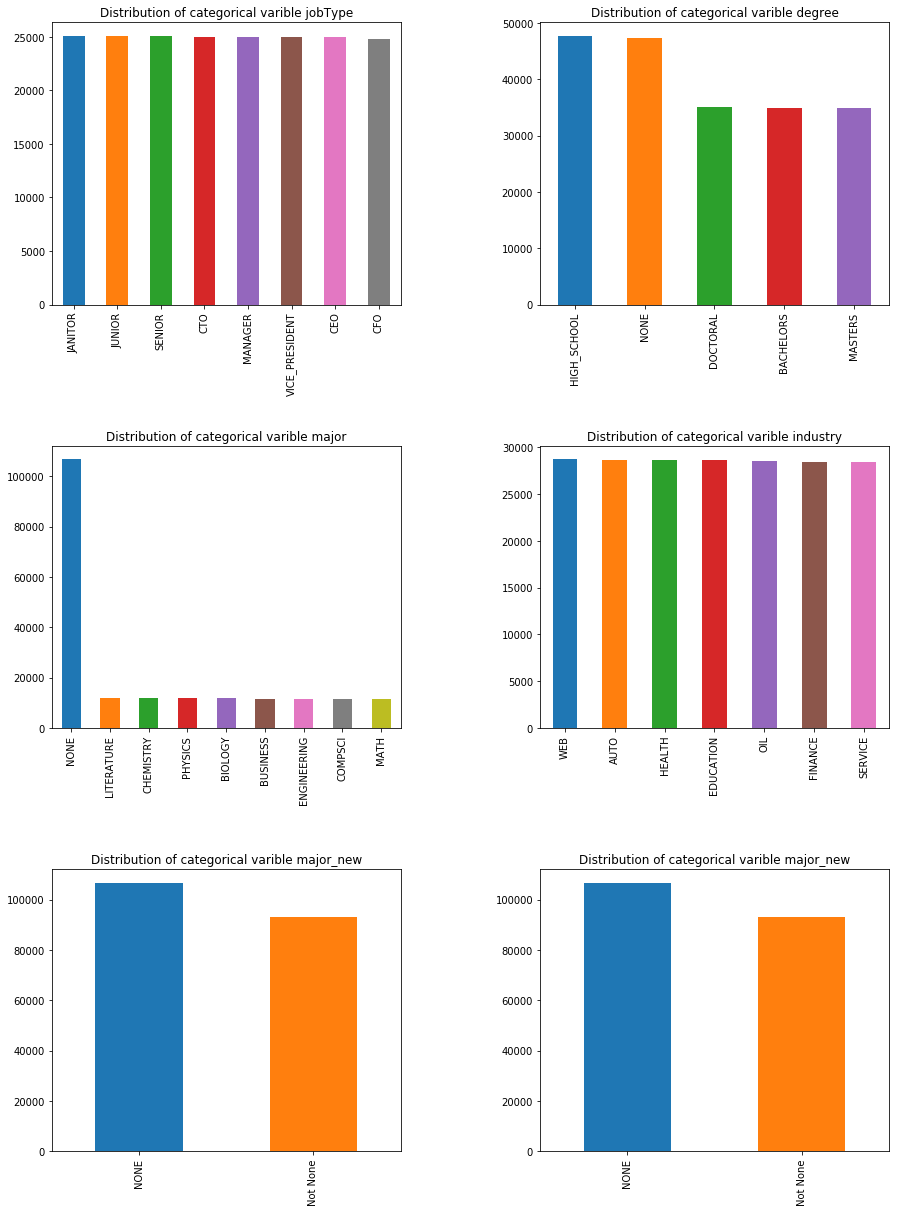

In [39]:
utils.plot_categorical_vars(X_test, categorical_vars + ['major_new'])

In [40]:
X_train.describe()

,yearsExperience,milesFromMetropolis
count,599814.000000,599814.000000
mean,11.986928,49.536343
std,7.215168,28.861836
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,74.000000
max,24.000000,99.000000


In [41]:
X_val.describe()

,yearsExperience,milesFromMetropolis
count,199939.000000,199939.000000
mean,11.985981,49.525355
std,7.207543,28.912261
min,0.000000,0.000000
25%,6.000000,24.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [42]:
X_test.describe()

,yearsExperience,milesFromMetropolis
count,199939.000000,199939.000000
mean,12.000635,49.567973
std,7.203972,28.874222
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [43]:
y_train.describe()

count    599814.000000
mean        116.046533
std          38.637024
min          18.000000
25%          89.000000
50%         114.000000
75%         141.000000
max         301.000000
Name: salary, dtype: float64

In [44]:
y_val.describe()

count    199939.000000
mean        116.064200
std          38.761044
min          17.000000
25%          88.000000
50%         114.000000
75%         141.000000
max         290.000000
Name: salary, dtype: float64

In [45]:
y_test.describe()

count    199939.000000
mean        115.934310
std          38.683312
min          18.000000
25%          88.000000
50%         114.000000
75%         141.000000
max         298.000000
Name: salary, dtype: float64

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


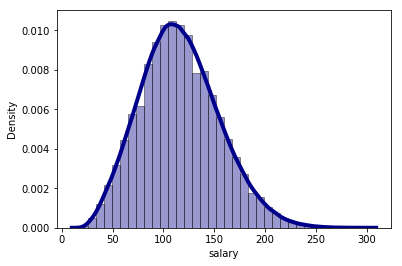

In [46]:
utils.hist_kdp(y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


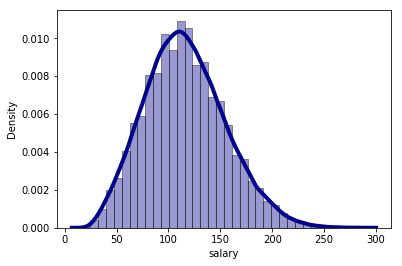

In [47]:
utils.hist_kdp(y_val)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


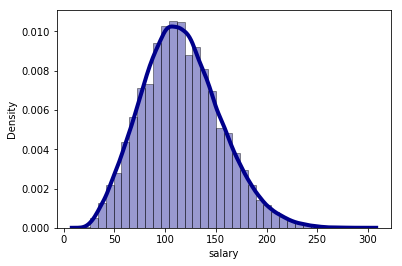

In [48]:
utils.hist_kdp(y_test)

In [49]:
baseline_train_pred = [y_train.mean()] * len(y_train)
baseline_val_pred = [y_train.mean()] * len(y_val)
baseline_test_pred = [y_train.mean()] * len(y_test)

In [50]:
from sklearn.metrics import mean_squared_error
import math
print("baseline RMSE of training set: ", math.sqrt(mean_squared_error(y_train, baseline_train_pred)))
print("baseline RMSE of validation set: ", math.sqrt(mean_squared_error(y_val, baseline_val_pred)))
print("baseline RMSE of testing set: ", math.sqrt(mean_squared_error(y_test, baseline_test_pred)))

baseline RMSE of training set:  38.636992209911234
baseline RMSE of validation set:  38.76095118995596
baseline RMSE of testing set:  38.68337820554536


## 5. Clean testing features

Cleaned the testing features like training features

* create `major_new` for testing
* drop `companyId`

In [51]:
test_features = pd.read_csv('test_features.csv')

In [52]:
test_features['major_new'] = test_features['major']
test_features.loc[(test_features.major != 'NONE'), 'major_new'] = 'Not None'
testing = test_features.drop(['companyId'], axis = 1)

Cleaned test_features data set have very similary distribution to cleaned train_features

In [53]:
testing.head()

,jobId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,major_new
0,JOB1362685407687,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73,NONE
1,JOB1362685407688,JUNIOR,NONE,NONE,AUTO,20,47,NONE
2,JOB1362685407689,CTO,MASTERS,BIOLOGY,HEALTH,17,9,Not None
3,JOB1362685407690,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96,NONE
4,JOB1362685407691,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44,Not None


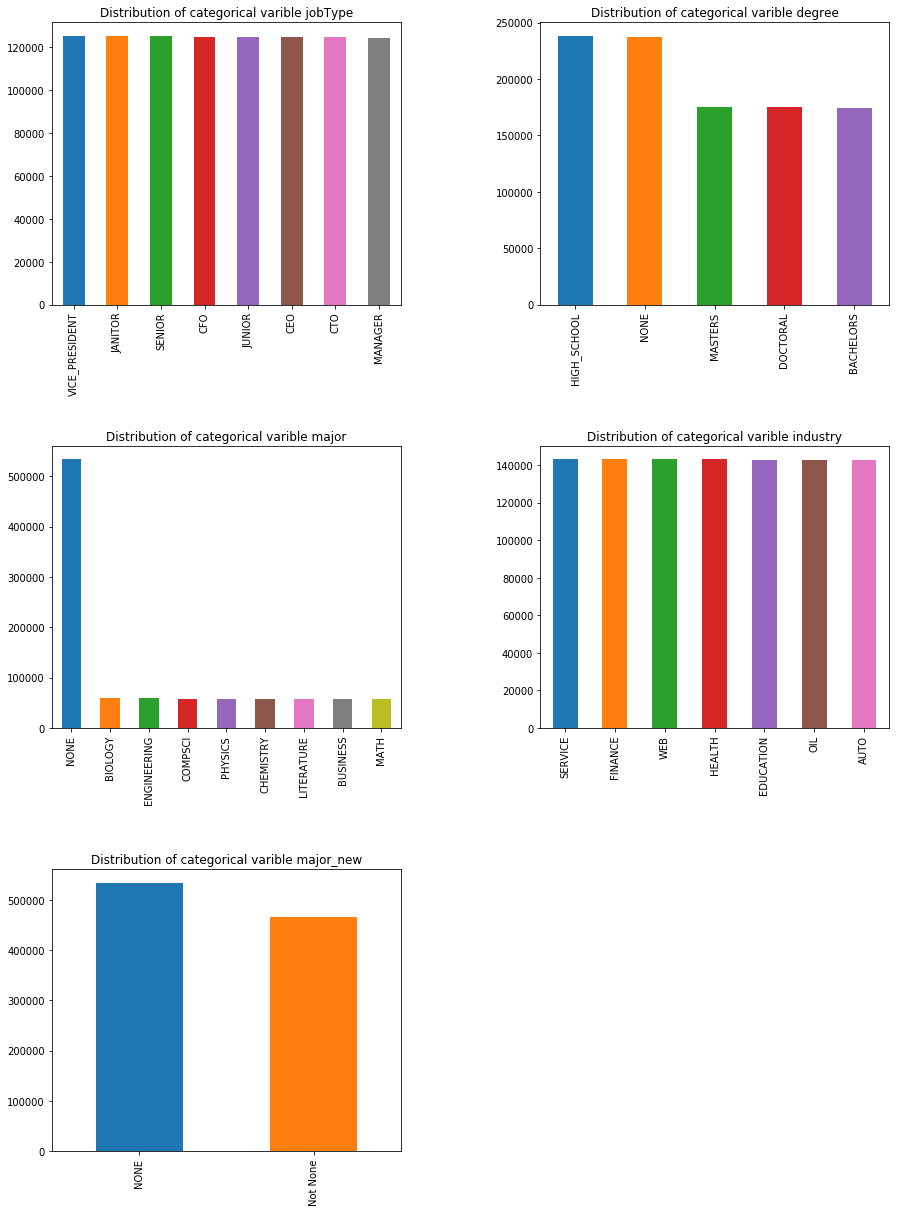

In [54]:
utils.plot_categorical_vars(testing, categorical_vars)

In [55]:
testing.describe()

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,12.002104,49.526414
std,7.213179,28.889713
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [56]:
z = set(training.jobId).intersection(set(testing.jobId)) 
print(z)
print(training.jobId.nunique() == len(training.jobId))
print(testing.jobId.nunique() == len(testing.jobId))

set()
True
True


## 6. Save all data sets 

Save all cleaned data sets for model developement in next notebooks

In [57]:
X_train.to_pickle("X_train.pkl")
X_val.to_pickle("X_val.pkl")
X_test.to_pickle("X_test.pkl")
y_train.to_pickle("y_train.pkl")
y_val.to_pickle("y_val.pkl")
y_test.to_pickle("y_test.pkl")

Save cleaned full training data (has salary) and testing data

In [58]:
training.to_pickle("training.pkl")
testing.to_pickle("testing.pkl")